In [1]:
!date

Thu Oct 22 17:14:04 PDT 2020


# Validate 10x and SS at with 3' amount

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("../../reference/t2g.txt", sep="\t", header=None, names=cols)

In [3]:
t2g["transcript_id"] = t2g["transcript_id"].str.slice(0,18)
t2g["gene_id"] = t2g["gene_id"].str.slice(0,18)

In [4]:
def swap_start(start, stop, strand):
    new_start = start
    new_stop = stop
    if strand=="-":
        new_start = stop
        new_stop = start
    return new_start, new_stop

In [5]:
tmp = t2g.apply(lambda x: swap_start(x["start"], x["stop"], x["strand"]), axis=1).tolist()
t2g[["new_start", "new_stop"]] = pd.DataFrame(tmp, columns=["new_start", "new_stop"])

In [6]:
t2g.index = t2g.transcript_id.values

# Group isoforms by (1) Gene and then (2) Transcripton stop sites

In [7]:
gb = t2g.groupby(["chromosome", "gene_id", "new_stop"])["transcript_id"].apply(list)
gb = gb.reset_index()
gb = gb.rename(columns={"transcript_id":"tss_same"})
gb["tss_len"] = gb["tss_same"].apply(lambda x: len(x))

In [8]:
gb["n_tss_same"]    = gb["tss_same"].apply(lambda x: len(x))

num_iso_per_gene   = t2g.groupby("gene_id")["transcript_id"].count()
max_tss_set_size    = gb.groupby("gene_id")["tss_len"].apply(max)
num_tss_with_1_iso  = gb.groupby("gene_id")["tss_len"].apply(lambda x: (np.array(x)==1).sum())

gb["n_iso"]         = gb["gene_id"].map(num_iso_per_gene)
gb["max_tss_size"]  = gb["gene_id"].map(max_tss_set_size)
gb["num_tss_1_iso"] = gb["gene_id"].map(num_tss_with_1_iso)

txn_list = gb["tss_same"].explode().values

#gb["tss_same"] = gb.tss_same.astype(str)
gb["tss_class"] = np.arange(gb.shape[0])

In [9]:
t2g = gb.sort_values("gene_id")

In [10]:
t2g

,chromosome,gene_id,new_stop,tss_same,tss_len,n_tss_same,n_iso,max_tss_size,num_tss_1_iso,tss_class
53497,3,ENSMUSG00000000001,108107280,[ENSMUST00000000001],1,1,1,1,1,53497
96853,X,ENSMUSG00000000003,77837901,[ENSMUST00000000003],1,1,2,1,2,96853
96854,X,ENSMUSG00000000003,77837902,[ENSMUST00000114041],1,1,2,1,2,96854
33970,16,ENSMUSG00000000028,18780447,[ENSMUST00000000028],1,1,4,1,4,33970
33971,16,ENSMUSG00000000028,18780453,[ENSMUST00000096990],1,1,4,1,4,33971
...,...,...,...,...,...,...,...,...,...,...
37311,16,ENSMUSG00000116987,91435293,[ENSMUST00000232135],1,1,1,1,1,37311
41253,17,ENSMUSG00000116988,8082695,[ENSMUST00000232307],1,1,1,1,1,41253
37312,16,ENSMUSG00000116989,90362580,[ENSMUST00000231361],1,1,1,1,1,37312
37313,16,ENSMUSG00000116993,86770227,[ENSMUST00000231875],1,1,2,1,2,37313


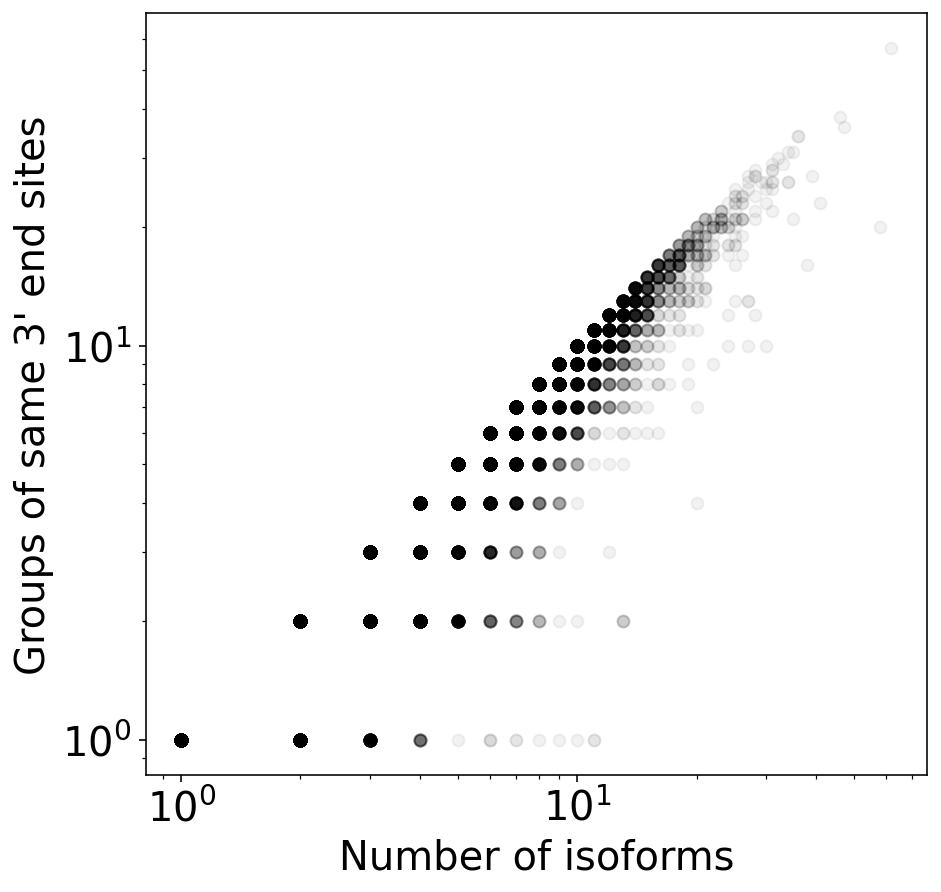

In [11]:
fig, ax = plt.subplots(figsize=(7,7))

x = t2g[~t2g["gene_id"].duplicated()]["n_iso"]
y = t2g.groupby("gene_id")["n_iso"].count()
alpha=0.05

ax.scatter(x,y, alpha=alpha, color="k")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Number of isoforms")
ax.set_ylabel("Groups of same 3' end sites")

plt.savefig(trackfig("../../figures/end_sites.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)


plt.show()

In [12]:
t2g.to_csv(trackfig("../../tables/unordered/t2g.csv", TRACKFIG, NB))